In [2]:
!hostname

gnode009.cluster


In [3]:
!nvidia-smi

Mon Sep 11 13:40:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:98:00.0 Off |                    0 |
| N/A   32C    P0   165W / 300W |  12434MiB / 81920MiB |     50%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)
import time

In [5]:
torch.cuda.is_available()

True

In [6]:
device = torch.device('cuda')

In [7]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


(400, 400) (400, 400) (400, 400)
(400, 400, 2)
CPU times: user 34.6 ms, sys: 2.81 ms, total: 37.4 ms
Wall time: 40.5 ms


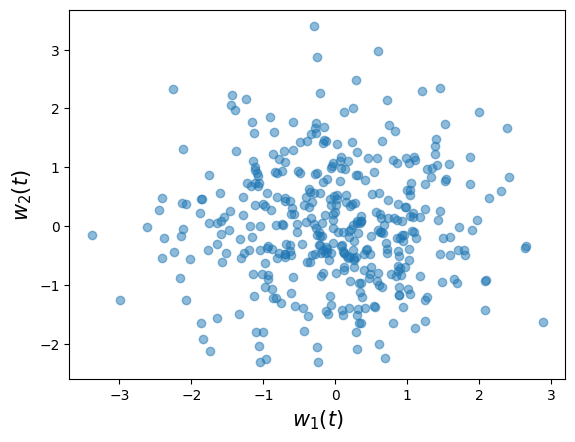

In [8]:
%%time

#### Generating SINN training data by solving SDE (Langevin dynamics)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad


#### Parameters 
batch = 400                            # Batch size 
sec_length = 400                       # Length of the input sequence 



# Construct the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
w1=np.random.randn(sec_length,batch)
w2=np.random.randn(sec_length,batch)
print(ini.shape, w1.shape, w2.shape)

plt.scatter(w1[:,0], w2[:,0], alpha=0.5)
plt.xlabel(r'$w_1(t)$',fontsize=15)
plt.ylabel(r'$w_2(t)$',fontsize=15)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = w1
Traj[:,:,1] = w2
T=np.arange(len(w1[:,1]))
x=np.linspace(-5,5,sec_length)
print(Traj.shape)

In [9]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


(array([-6., -4., -2.,  0.,  2.,  4.,  6.]),
 [Text(0, -6.0, '−6'),
  Text(0, -4.0, '−4'),
  Text(0, -2.0, '−2'),
  Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6')])

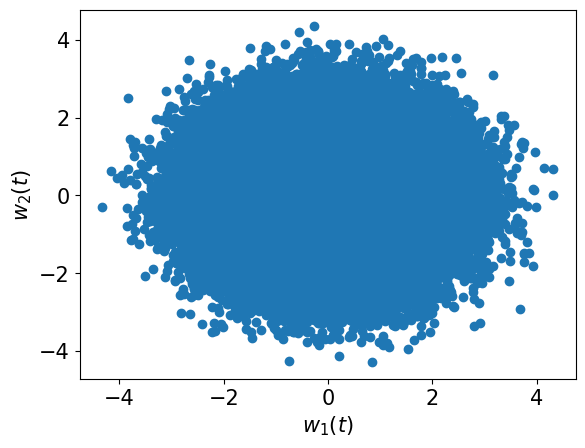

In [10]:
plt.scatter(Traj[:,:,0], Traj[:,:,1])
plt.xlabel(r'$w_1(t)$',fontsize=15)
plt.ylabel(r'$w_2(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [11]:
# Defining Loss functions
LAGS = 400
N = 20
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical = make_loss('pdf2D', target, lower=-5, upper=5, n=N, bw=None, device=device)

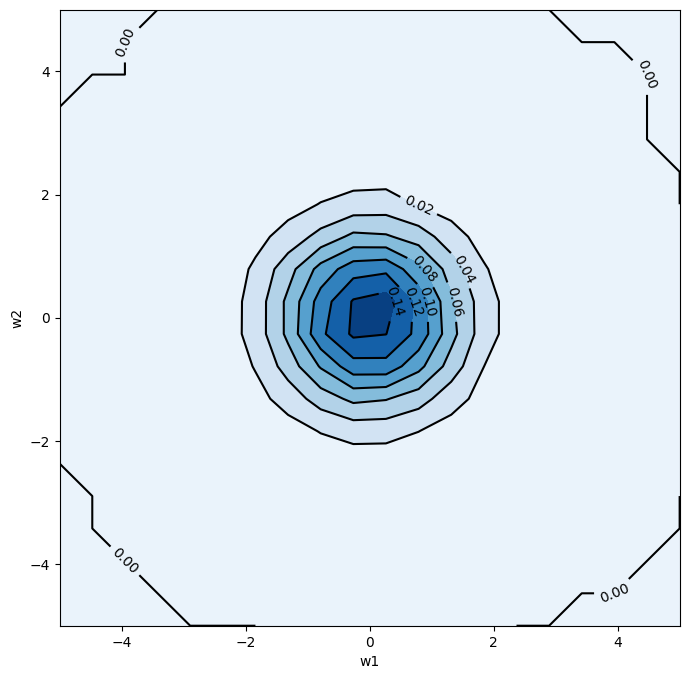

In [12]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5

xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# plt.contour(loss_pdf_empirical._target.cpu())
# Contourf plot
cfset = ax.contourf(xx, yy, loss_pdf_empirical._target.cpu(), cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, loss_pdf_empirical._target.cpu(), colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('w1')
ax.set_ylabel('w2')

plt.show()

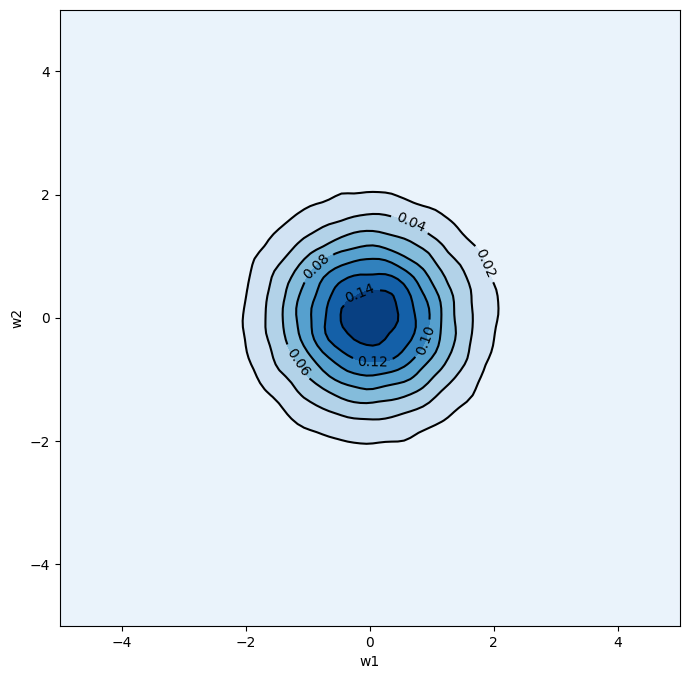

In [13]:
import scipy.stats as st

x = Traj[..., 0].ravel()
y = Traj[..., 1].ravel()
xmin, xmax = -5, 5
ymin, ymax = -5, 5

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('w1')
ax.set_ylabel('w2')

plt.show()

torch.Size([400, 2])


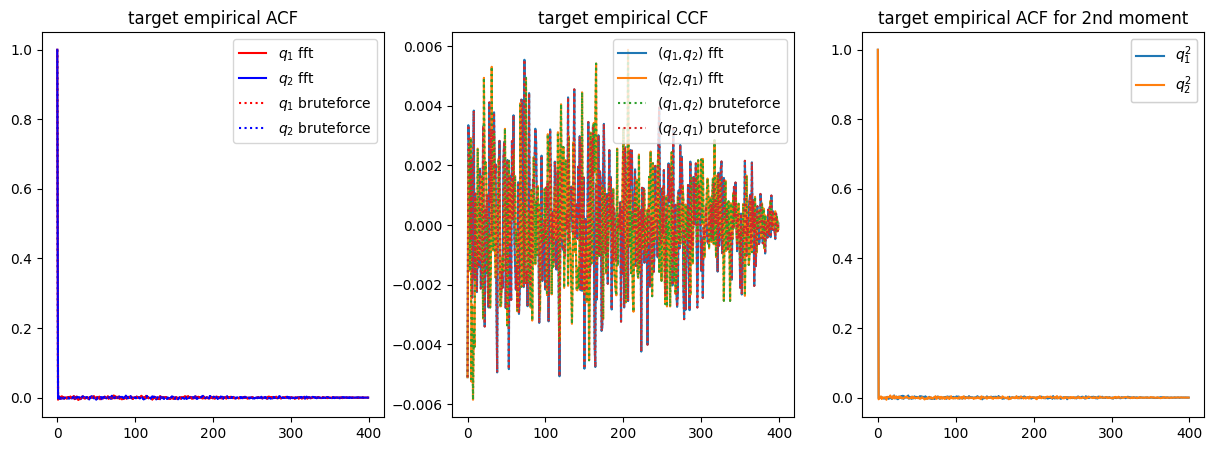

In [14]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_1$ fft')
axs[0].plot(loss_acf_fft._target.cpu()[...,-1],'b', label=r'$q_2$ fft')
axs[0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_1$ bruteforce')
axs[0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_2$ bruteforce')
axs[0].legend()
axs[0].set_title('target empirical ACF')

axs[1].plot(loss_ccf_fft._target.cpu()[...,0], label=r'($q_1$,$q_2$) fft')
axs[1].plot(loss_ccf_fft._target.cpu()[...,1], label=r'($q_2$,$q_1$) fft')
axs[1].plot(loss_ccf_bruteforce._target.cpu()[...,0],':',label=r'($q_1$,$q_2$) bruteforce')
axs[1].plot(loss_ccf_bruteforce._target.cpu()[...,1],':',label=r'($q_2$,$q_1$) bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[1].legend()
axs[1].set_title('target empirical CCF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[2].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[2].legend(iter(sec_moment), (r'$q_1^2$', r'$q_2^2$'),loc=1)
axs[2].set_title('target empirical ACF for 2nd moment')
axs[2].add_artist(legend4)

plt.show()

In [14]:
class Model:
    def __init__(self, net):

        self.x_acf_s = None
        self.x_ccf_s = None
        self.x_pdf_s = None
        self.x_acf2_s = None
        self.s_collect = []

        self.net = net

        self.T_error=[]
        self.V_error=[]
        self.T_ccf=[]
        self.V_ccf=[]
        self.T_pdf=[]
        self.V_pdf=[]
        self.T_acf=[]
        self.V_acf=[]
        self.T_acf2=[]
        self.V_acf2=[]
        self.Step=[]
        self.iter = 0

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_acf, loss_ccf, loss_pdf, loss_acf2):
        loss = torch.exp(-self.x_acf_s) * loss_acf.detach() + self.x_acf_s \
               + torch.exp(-self.x_ccf_s) * loss_ccf.detach() + self.x_ccf_s \
               + torch.exp(-self.x_pdf_s) * loss_pdf.detach() + self.x_pdf_s \
               + torch.exp(-self.x_acf2_s) * loss_acf2.detach() + self.x_acf2_s
        return loss

    def true_loss(self, loss_acf, loss_ccf, loss_pdf, loss_acf2):
        return torch.exp(-self.x_acf_s.detach()) * loss_acf + torch.exp(-self.x_ccf_s.detach()) * loss_ccf + torch.exp(-self.x_pdf_s.detach()) * loss_pdf + torch.exp(-self.x_acf2_s.detach()) * loss_acf2


    def run_baseline(self):
        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        for step in range(20000):
            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.6f, pdf: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if acf <=0.0001 and ccf <=0.00001 and pdf<=0.00002 and acf_sec_moment<=0.0001:
                break

        if acf <=0.0001 and ccf <=0.00001 and pdf<=0.00002 and acf_sec_moment<=0.0001:
            print ('Training failed')
        print('Training finished')



    def run_AW(self):
        self.x_acf_s = nn.Parameter(self.x_acf_s, requires_grad=True)
        self.x_ccf_s = nn.Parameter(self.x_ccf_s, requires_grad=True)
        self.x_pdf_s = nn.Parameter(self.x_pdf_s, requires_grad=True)
        self.x_acf2_s = nn.Parameter(self.x_acf2_s, requires_grad=True)


        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        optimizer_adam_weight = optim.Adam([self.x_acf_s] + [self.x_ccf_s] + [self.x_pdf_s] + [self.x_acf2_s],
                                                     lr=1e-3)

        for step in range(20000):
            self.s_collect.append([self.iter, self.x_acf_s.item(), self.x_ccf_s.item(), self.x_pdf_s.item(), self.x_acf2_s.item()])

            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.6f, pdf: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if acf <=0.0001 and ccf <=0.00001 and pdf<=0.00002 and acf_sec_moment<=0.0001:
                break
            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam_weight.step()
            
        if acf > 0.0001 or ccf > 0.00001 or pdf >0.00002 or acf_sec_moment>0.0001:
            print ('Training failed')
        print('Training finished')


    def train(self):
        self.x_acf_s = torch.tensor(2.).float()
        self.x_ccf_s = torch.tensor(1.).float()
        self.x_pdf_s = torch.tensor(0.).float()
        self.x_acf2_s = torch.tensor(2.).float()
        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AW()
        elapsed = time.time() - start_time
        print('Training time: %.2f' % elapsed)

In [15]:
### Defining SINN model
net = SINN(1, 10, 2, 2).to(device)
model = Model(net=net)

model_type = 1 # 0: baseline 1: AW

In [16]:
model.train()

[0]-th step loss: 0.0108, 0.0099, acf: 0.00259, ccf: 0.004737, pdf: 0.00062, acf2: 0.00191
[50]-th step loss: 0.0026, 0.0026, acf: 0.00068, ccf: 0.000678, pdf: 0.00060, acf2: 0.00059
[100]-th step loss: 0.0016, 0.0016, acf: 0.00048, ccf: 0.000153, pdf: 0.00060, acf2: 0.00033
[150]-th step loss: 0.0010, 0.0010, acf: 0.00025, ccf: 0.000051, pdf: 0.00060, acf2: 0.00011
[200]-th step loss: 0.0008, 0.0008, acf: 0.00016, ccf: 0.000029, pdf: 0.00060, acf2: 0.00005
[250]-th step loss: 0.0008, 0.0008, acf: 0.00011, ccf: 0.000018, pdf: 0.00060, acf2: 0.00003
[300]-th step loss: 0.0007, 0.0007, acf: 0.00007, ccf: 0.000013, pdf: 0.00060, acf2: 0.00002
[350]-th step loss: 0.0007, 0.0007, acf: 0.00005, ccf: 0.000009, pdf: 0.00060, acf2: 0.00001
[400]-th step loss: 0.0007, 0.0006, acf: 0.00003, ccf: 0.000008, pdf: 0.00060, acf2: 0.00001
[450]-th step loss: 0.0006, 0.0006, acf: 0.00002, ccf: 0.000007, pdf: 0.00060, acf2: 0.00001
[500]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000007, pdf: 0.0

[4400]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[4450]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[4500]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[4550]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[4600]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[4650]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[4700]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[4750]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[4800]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[4850]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[4900]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.00

[8800]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[8850]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[8900]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[8950]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[9000]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[9050]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[9100]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[9150]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[9200]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[9250]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[9300]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.00

[13150]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[13200]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[13250]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[13300]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[13350]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[13400]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[13450]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00061, acf2: 0.00001
[13500]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[13550]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[13600]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[13650]-th step loss: 0.0006, 0.0006, acf: 0.00001

[17500]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[17550]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[17600]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[17650]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[17700]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[17750]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[17800]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[17850]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[17900]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000005, pdf: 0.00060, acf2: 0.00001
[17950]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[18000]-th step loss: 0.0006, 0.0006, acf: 0.00001

In [17]:
def draw_loss(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.loglog(model.Step, model.T_error,'r',label='Training error')
    plt.loglog(model.Step, model.V_error,'b--',label='Validation error')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [18]:
def draw_errors(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
    plt.loglog(model.Step, model.T_error,'k',label='Training error')
    plt.loglog(model.Step, model.V_error,'k--')
    plt.loglog(model.Step, model.T_acf,'r',label='acf error')
    plt.loglog(model.Step, model.V_acf,'r--')
    plt.loglog(model.Step, model.T_ccf,'b',label='ccf error')
    plt.loglog(model.Step, model.V_ccf,'b--')
    plt.loglog(model.Step, model.T_pdf,'y',label='pdf error')
    plt.loglog(model.Step, model.V_pdf,'y--')
    plt.loglog(model.Step, model.T_acf2,'g',label='acf2 error')
    plt.loglog(model.Step, model.V_acf2,'g--')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [19]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.exp(-s_collect[:, 1]), 'r-', label=r'$e^{-s_{acf}}$')
    plt.plot(s_collect[:, 0], np.exp(-s_collect[:, 2]), 'b-', label='$e^{-s_{ccf}}$')
    plt.plot(s_collect[:, 0], np.exp(-s_collect[:, 3]), 'y-', label='$e^{-s_{pdf}}$')
    plt.plot(s_collect[:, 0], np.exp(-s_collect[:, 4]), 'g-', label='$e^{-s_{acf2}}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\lambda$')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

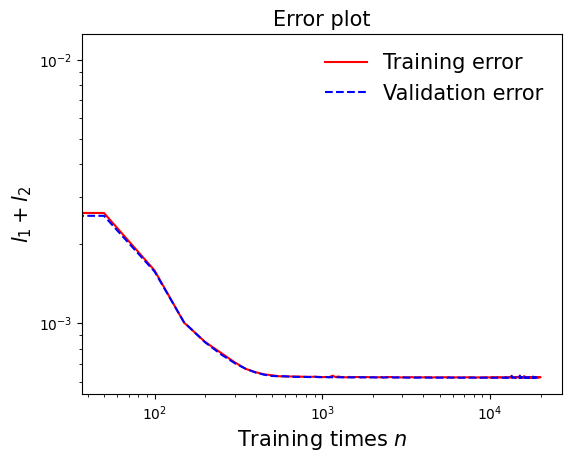

In [20]:
draw_loss(model)

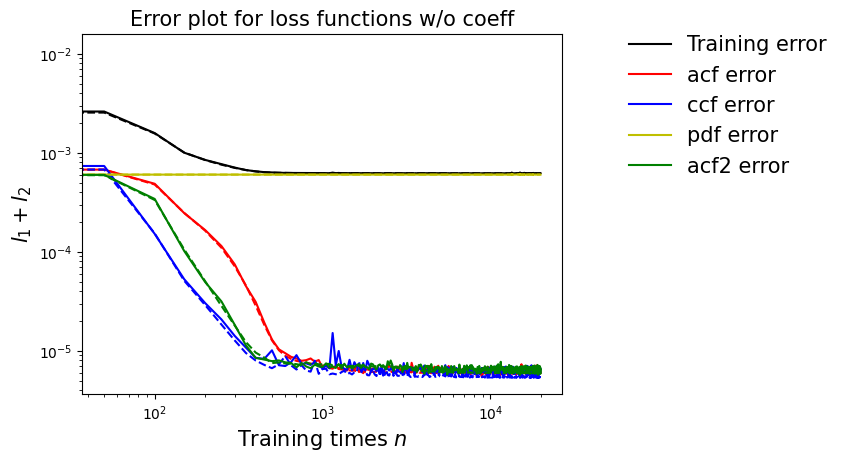

In [21]:
draw_errors(model)

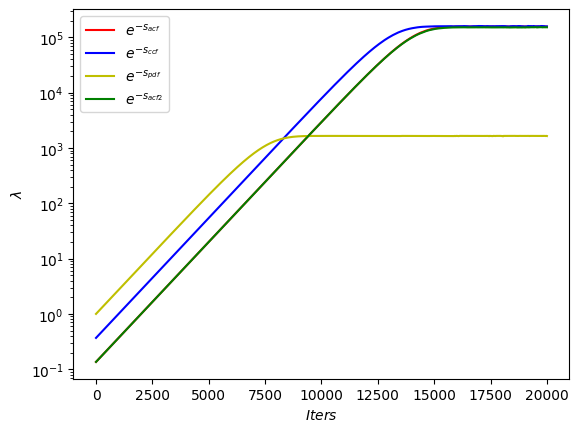

In [22]:
draw_epoch_w(model)

In [23]:
def test1(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:20]-T[skip], Traj[skip:20, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$w_1(t)$ and $w_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:20]-T[skip], prediction[skip:20, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$w_1(t)$ and $w_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

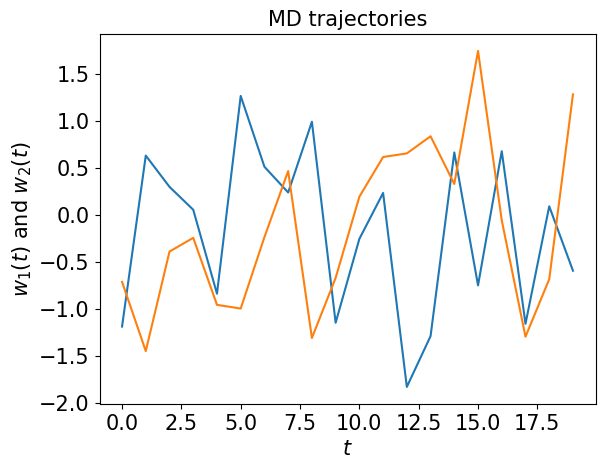

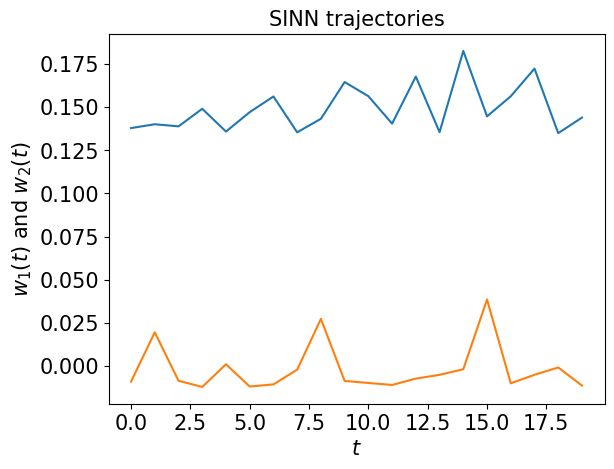

In [24]:
test1(model)

In [25]:
def test2(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
    acf_t=StatLoss.acf(target)
    corr_p1=acf_p.detach().cpu().numpy()
    corr_t1=acf_t.detach().cpu().numpy()
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p2=ccf_p.detach().cpu().numpy()
    corr_t2=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $w_1$',fontsize=15)    
    plt.plot(T, corr_t1[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $w_2$',fontsize=15)          
    plt.plot(T, corr_t1[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T[:50], corr_t2[0:50,:],'r')        # correlation function of the target 
    plt.plot(T[:50], corr_p2[0:50,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
#     plt.plot(T, corr_t2[:,:],'r')        # correlation function of the target 
#     plt.plot(T, corr_p2[:,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylim(-0.05,0.05)

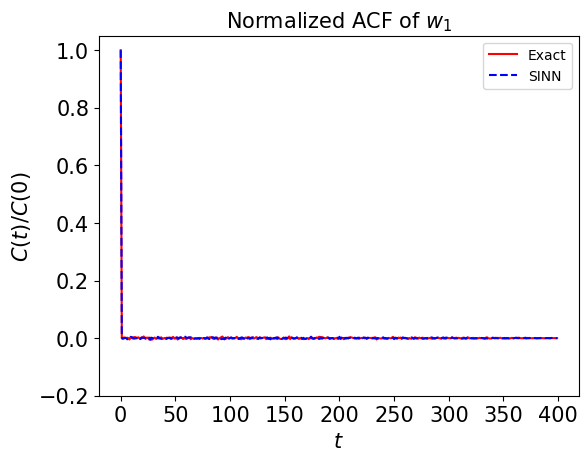

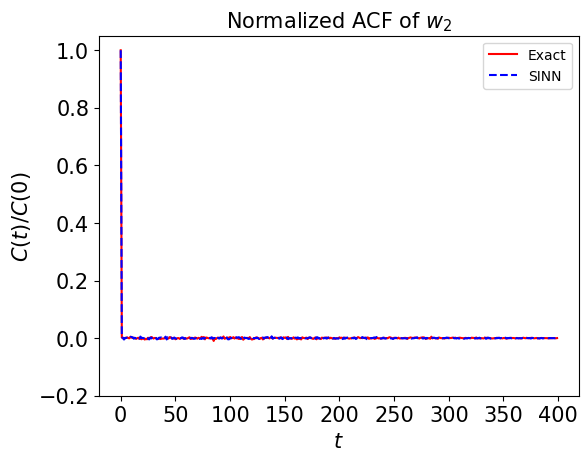

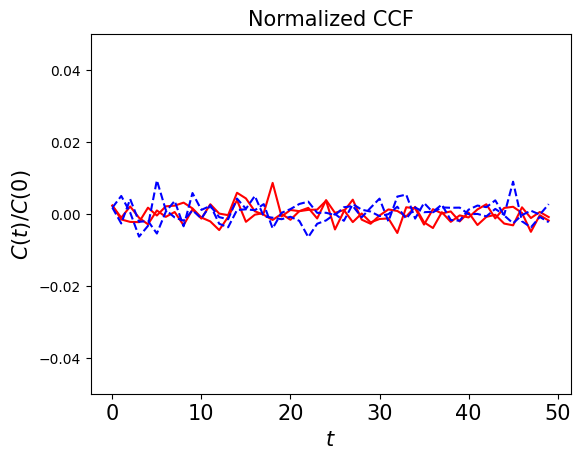

In [26]:
test2(model)

In [27]:
def test3(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 100,None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100,None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100,None).cpu()


    x=np.linspace(-5, 5, 100)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_1$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_2$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_1$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

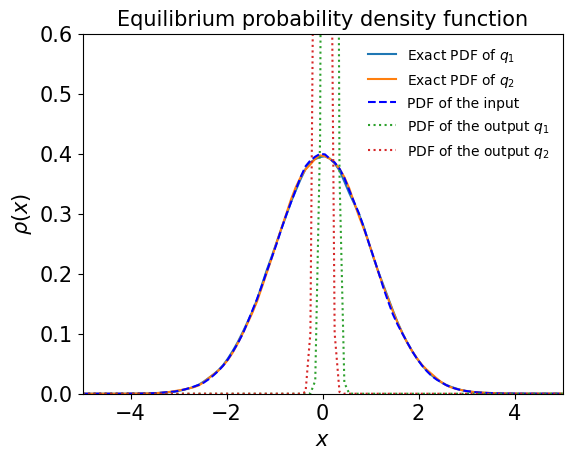

In [28]:
test3(model)

In [29]:
def test4(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $w_1^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $w_2^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()  

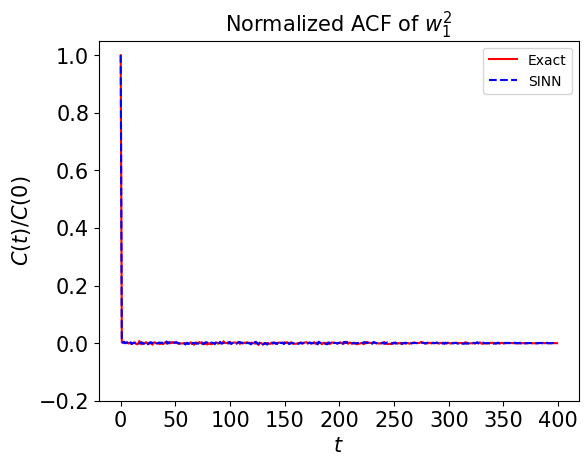

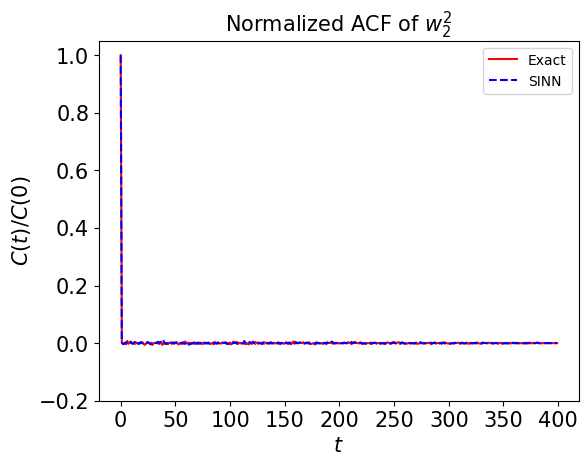

In [30]:
test4(model)

In [31]:
def test5(model):
    # Test 5: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.scatter(Traj[:,:,0], Traj[:,:,1])
    plt.xlabel(r'$w_1(t)$',fontsize=15)
    plt.ylabel(r'$w_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 
    plt.xlim(-5,5)
    plt.ylim(-5,5)


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.scatter(prediction[:,:,0],prediction[:,:,1])
    plt.xlabel(r'$w_1(t)$',fontsize=15)
    plt.ylabel(r'$w_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)   
    plt.xlim(-5,5)
    plt.ylim(-5,5)

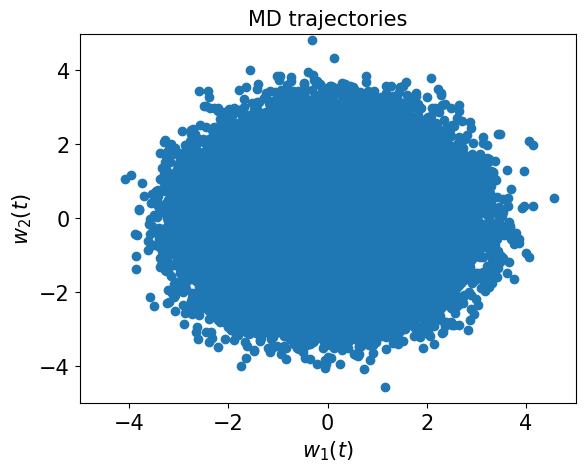

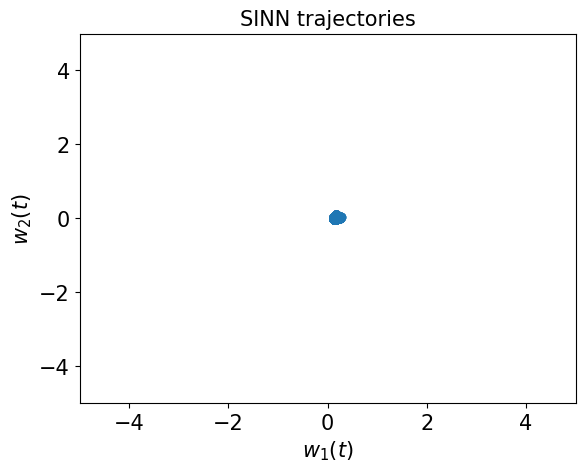

In [32]:
test5(model)

# 2 inputs

In [33]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


# Traj = Traj.astype(np.float32) 
# target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [34]:
### Defining SINN model
net = SINN(2, 10, 2, 2).to(device)
model = Model(net=net)

In [35]:
model.train()

[0]-th step loss: 0.1298, 0.1025, acf: 0.00257, ccf: 0.000136, pdf: 0.09724, acf2: 0.00257
[50]-th step loss: 0.0050, 0.0050, acf: 0.00215, ccf: 0.000065, pdf: 0.00065, acf2: 0.00214
[100]-th step loss: 0.0035, 0.0035, acf: 0.00136, ccf: 0.000103, pdf: 0.00064, acf2: 0.00135
[150]-th step loss: 0.0024, 0.0025, acf: 0.00084, ccf: 0.000149, pdf: 0.00064, acf2: 0.00083
[200]-th step loss: 0.0020, 0.0020, acf: 0.00063, ccf: 0.000095, pdf: 0.00064, acf2: 0.00062
[250]-th step loss: 0.0017, 0.0016, acf: 0.00047, ccf: 0.000056, pdf: 0.00064, acf2: 0.00047
[300]-th step loss: 0.0014, 0.0014, acf: 0.00034, ccf: 0.000038, pdf: 0.00064, acf2: 0.00034
[350]-th step loss: 0.0011, 0.0011, acf: 0.00023, ccf: 0.000027, pdf: 0.00063, acf2: 0.00023
[400]-th step loss: 0.0009, 0.0009, acf: 0.00015, ccf: 0.000020, pdf: 0.00063, acf2: 0.00014
[450]-th step loss: 0.0008, 0.0008, acf: 0.00009, ccf: 0.000015, pdf: 0.00063, acf2: 0.00008
[500]-th step loss: 0.0007, 0.0007, acf: 0.00005, ccf: 0.000012, pdf: 0.0

[4400]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[4450]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000007, pdf: 0.00063, acf2: 0.00001
[4500]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[4550]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[4600]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[4650]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[4700]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[4750]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[4800]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[4850]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[4900]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.00

[8800]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[8850]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[8900]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[8950]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[9000]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000007, pdf: 0.00063, acf2: 0.00001
[9050]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[9100]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[9150]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[9200]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[9250]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[9300]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.00

[13150]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[13200]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[13250]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[13300]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[13350]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[13400]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[13450]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[13500]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[13550]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[13600]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00063, acf2: 0.00001
[13650]-th step loss: 0.0006, 0.0006, acf: 0.00001

[17500]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00054, acf2: 0.00001
[17550]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00054, acf2: 0.00001
[17600]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00054, acf2: 0.00001
[17650]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00054, acf2: 0.00001
[17700]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00054, acf2: 0.00001
[17750]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00054, acf2: 0.00001
[17800]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00054, acf2: 0.00001
[17850]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00054, acf2: 0.00001
[17900]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00054, acf2: 0.00001
[17950]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00054, acf2: 0.00001
[18000]-th step loss: 0.0006, 0.0006, acf: 0.00001

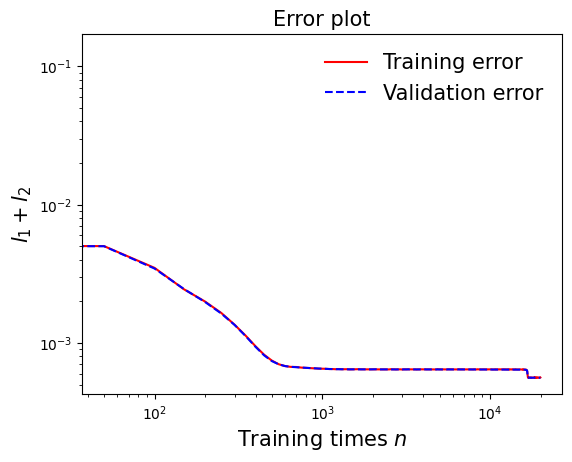

In [36]:
draw_loss(model)

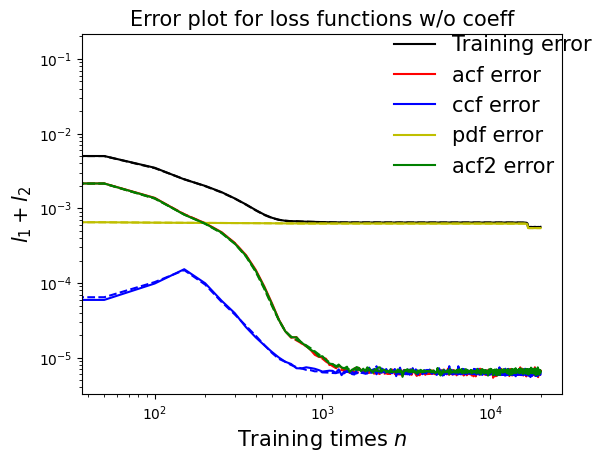

In [37]:
draw_errors(model)

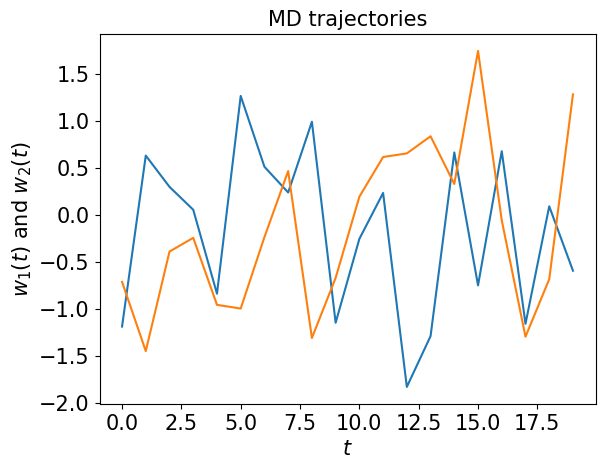

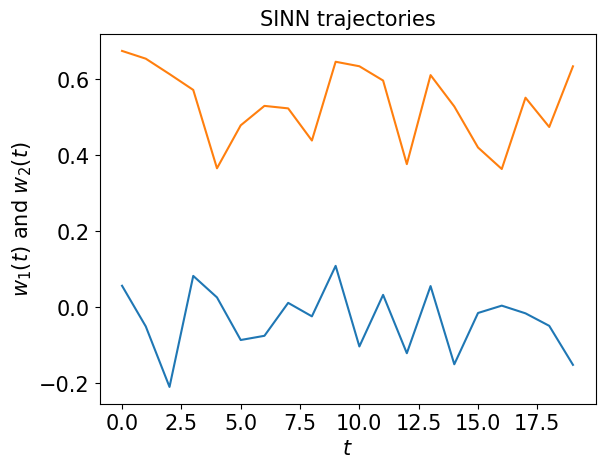

In [38]:
test1(model)

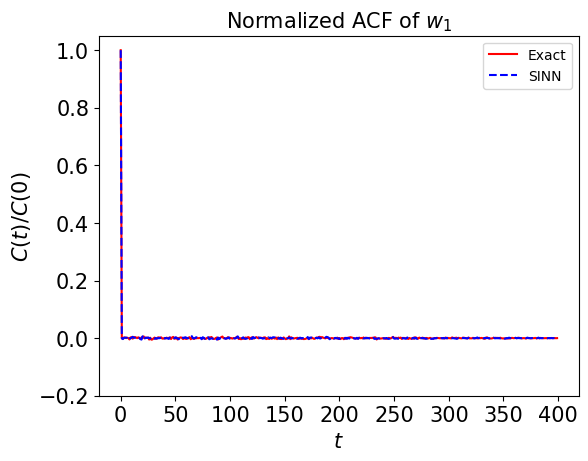

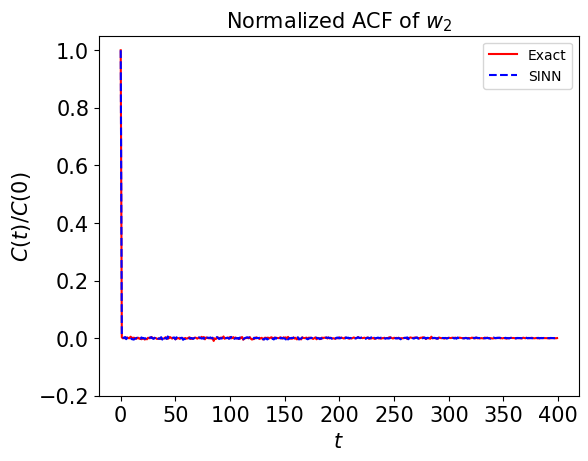

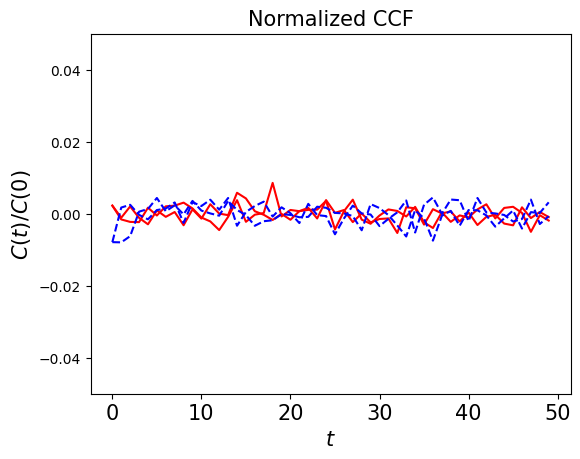

In [39]:
test2(model)

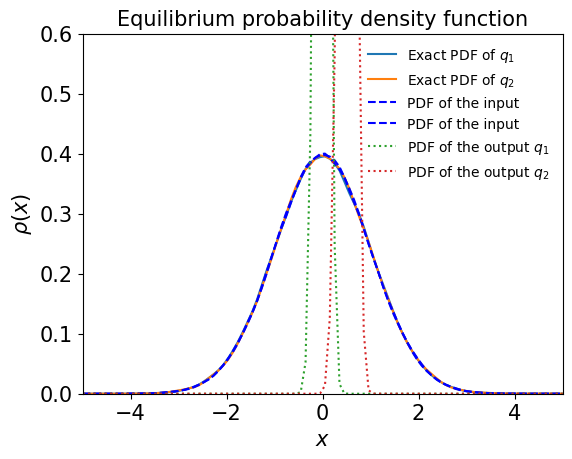

In [40]:
test3(model)

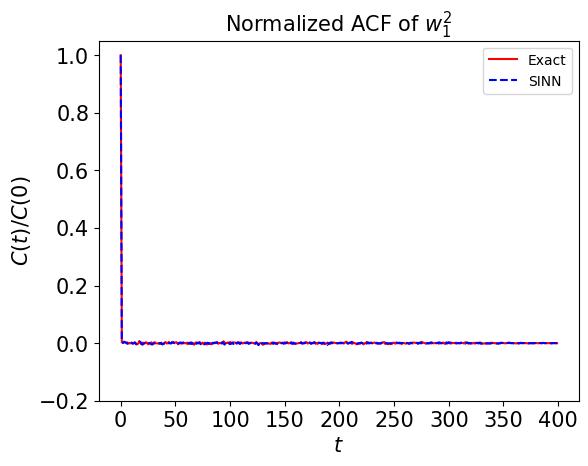

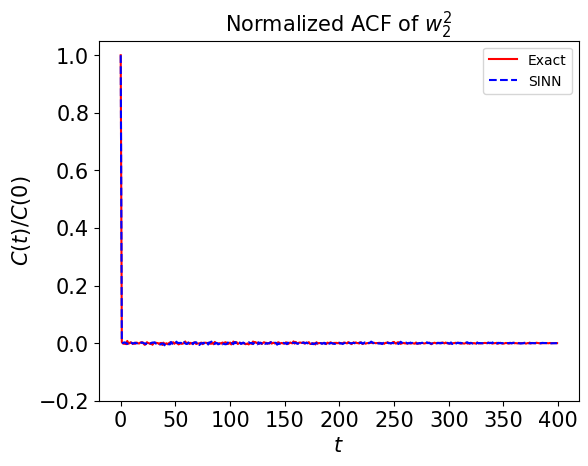

In [41]:
test4(model)

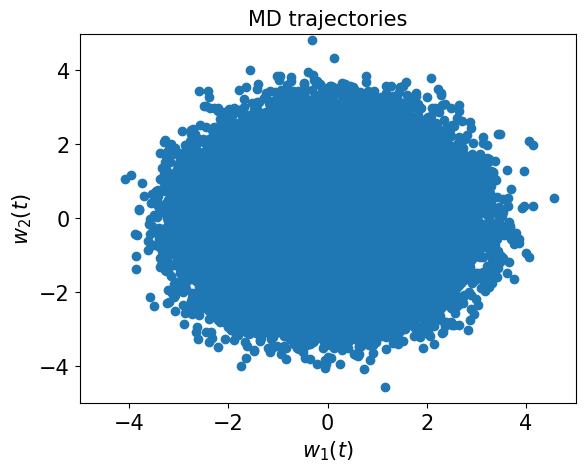

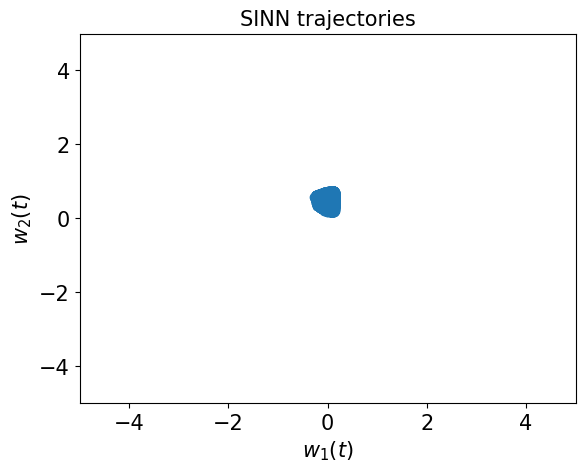

In [42]:
test5(model)

In [43]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,3*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 3)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 3), device=device)


# Traj = Traj.astype(np.float32) 
# target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 3]) torch.float32
The torch validation size is torch.Size([800, 400, 3]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [44]:
### Defining SINN model
net = SINN(3, 10, 2, 2).to(device)
model = Model(net=net)

In [45]:
model.train()

[0]-th step loss: 0.0409, 0.0342, acf: 0.00251, ccf: 0.003100, pdf: 0.02608, acf2: 0.00251
[50]-th step loss: 0.0044, 0.0043, acf: 0.00202, ccf: 0.000146, pdf: 0.00069, acf2: 0.00147
[100]-th step loss: 0.0027, 0.0027, acf: 0.00124, ccf: 0.000076, pdf: 0.00065, acf2: 0.00077
[150]-th step loss: 0.0019, 0.0019, acf: 0.00079, ccf: 0.000037, pdf: 0.00062, acf2: 0.00045
[200]-th step loss: 0.0013, 0.0013, acf: 0.00041, ccf: 0.000020, pdf: 0.00061, acf2: 0.00023
[250]-th step loss: 0.0010, 0.0009, acf: 0.00023, ccf: 0.000010, pdf: 0.00060, acf2: 0.00011
[300]-th step loss: 0.0008, 0.0008, acf: 0.00014, ccf: 0.000007, pdf: 0.00060, acf2: 0.00005
[350]-th step loss: 0.0007, 0.0007, acf: 0.00010, ccf: 0.000007, pdf: 0.00060, acf2: 0.00003
[400]-th step loss: 0.0007, 0.0007, acf: 0.00007, ccf: 0.000008, pdf: 0.00060, acf2: 0.00002
[450]-th step loss: 0.0007, 0.0007, acf: 0.00005, ccf: 0.000008, pdf: 0.00060, acf2: 0.00002
[500]-th step loss: 0.0007, 0.0007, acf: 0.00004, ccf: 0.000008, pdf: 0.0

[4400]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[4450]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[4500]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[4550]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[4600]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[4650]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[4700]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000007, pdf: 0.00060, acf2: 0.00001
[4750]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[4800]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000007, pdf: 0.00060, acf2: 0.00001
[4850]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[4900]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.00

[8800]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000007, pdf: 0.00060, acf2: 0.00001
[8850]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[8900]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[8950]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[9000]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000007, pdf: 0.00060, acf2: 0.00001
[9050]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[9100]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[9150]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[9200]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[9250]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[9300]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.00

[13150]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[13200]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[13250]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[13300]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[13350]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[13400]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000007, pdf: 0.00060, acf2: 0.00001
[13450]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[13500]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[13550]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[13600]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[13650]-th step loss: 0.0006, 0.0006, acf: 0.00001

[17500]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[17550]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[17600]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[17650]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[17700]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[17750]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[17800]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00061, acf2: 0.00001
[17850]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[17900]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[17950]-th step loss: 0.0006, 0.0006, acf: 0.00001, ccf: 0.000006, pdf: 0.00060, acf2: 0.00001
[18000]-th step loss: 0.0006, 0.0006, acf: 0.00001

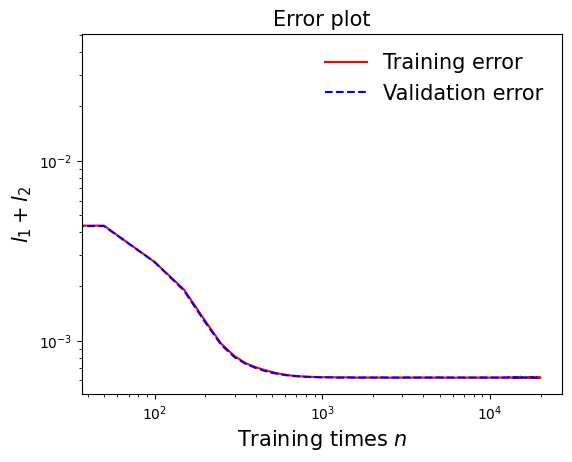

In [46]:
draw_loss(model)

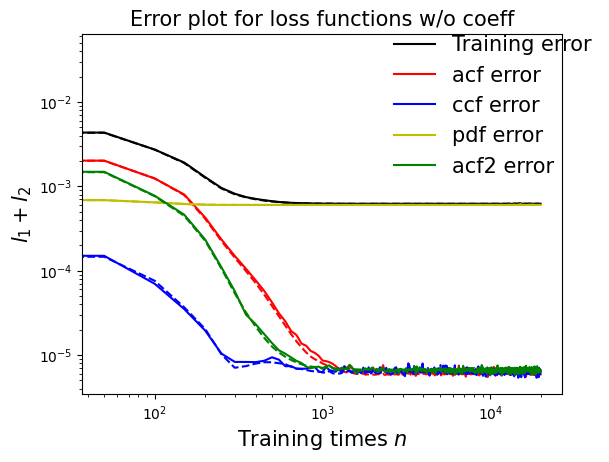

In [47]:
draw_errors(model)

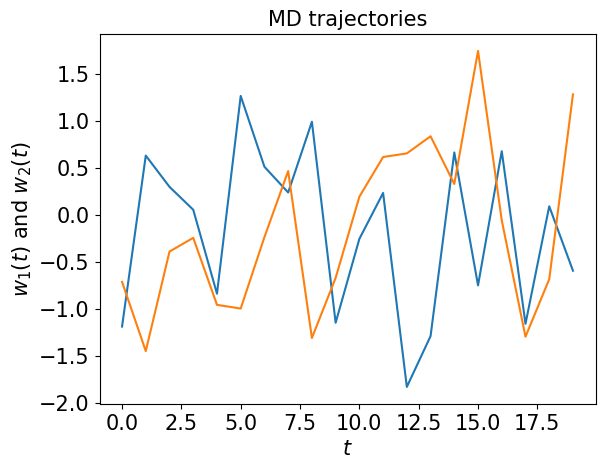

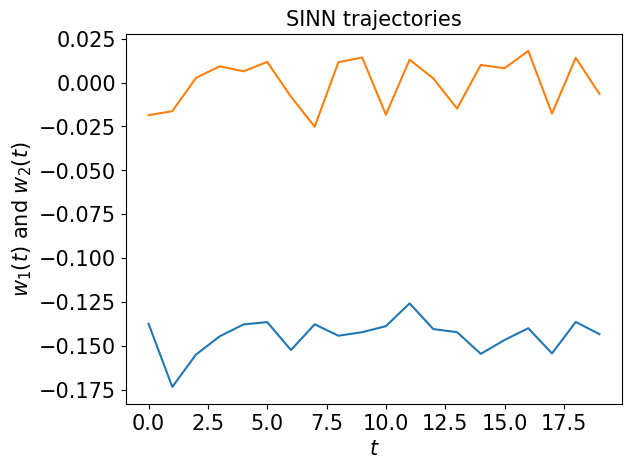

In [48]:
test1(model)

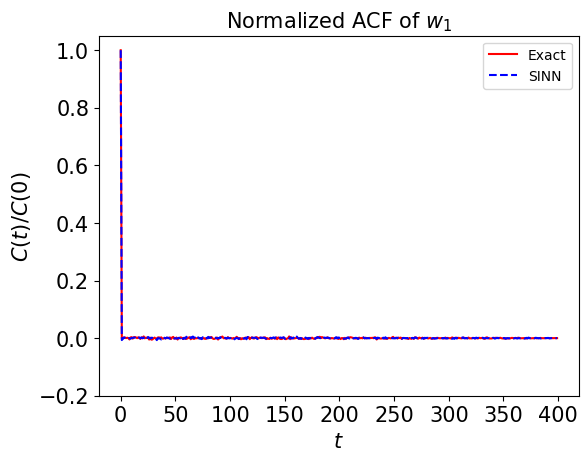

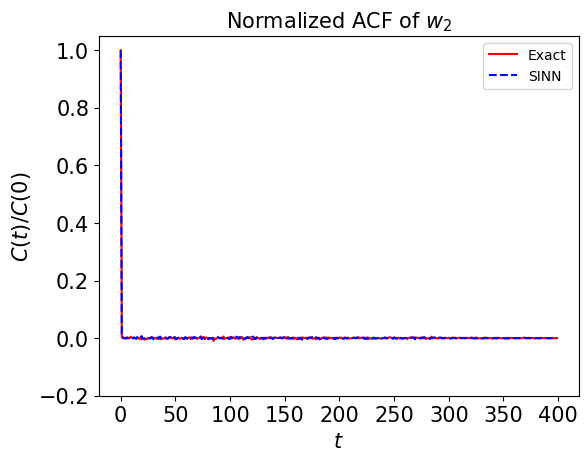

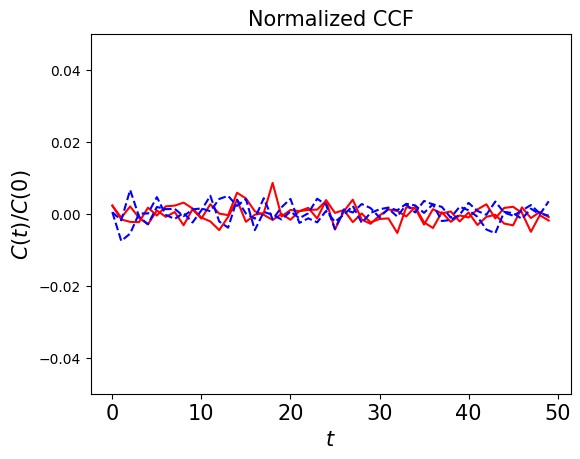

In [49]:
test2(model)

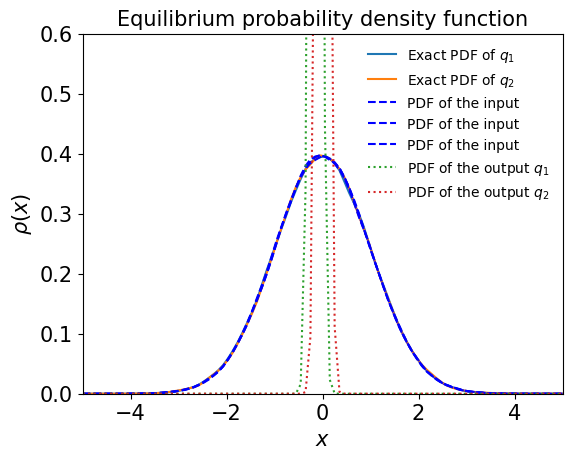

In [50]:
test3(model)

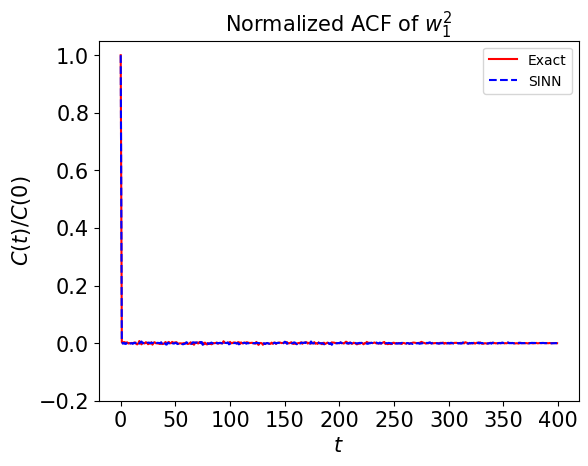

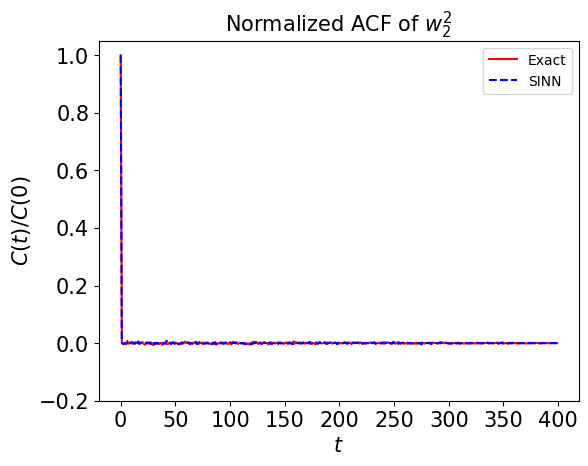

In [51]:
test4(model)

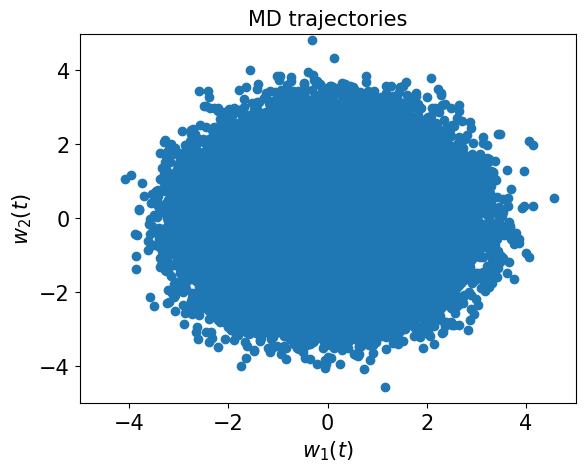

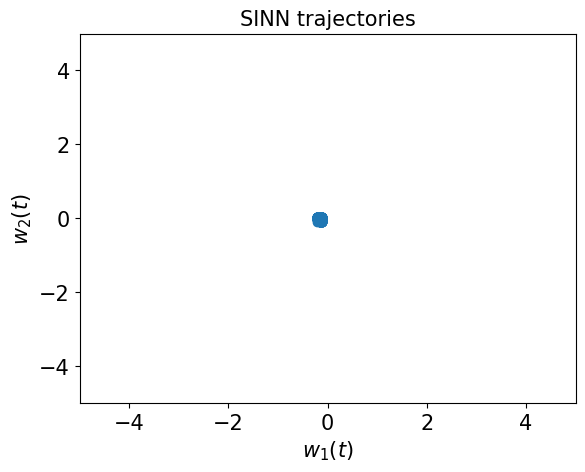

In [52]:
test5(model)